# Logistic Regression strategy
With this strategy we want to predict if the price of the following time step will be greater or lower than the current price. For this reason we can use a logistic regression model: it is used as a classifier and it will classify the class as +1 if the price will go up and -1 if it'll go down. In this way we can decide to take a long or short trading postion.

In [1]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np

In [144]:
ticker = 'EURUSD=X'
start = '2010-10-10'
end = '2022-10-10'
interval = '1d'
train = yf.download(ticker, start=start, end=end, interval=interval)['Adj Close'].to_frame()

[*********************100%%**********************]  1 of 1 completed


In [145]:
train['logRet'] = np.log(train['Adj Close']/train['Adj Close'].shift(1))

In [146]:
# Is the sign of the logReturn: it indicates if the price went up or down compared to the past day
# This is what we want to predict
train['direction'] = np.sign(train.logRet)

In [147]:
# Number of logReturn lags to consider for the prediction
lags = 60
# Columns labels of the logRet-n
col_names = []

for lag in range(1,lags+1):
    col_name = 'logRet'+str(lag)
    col_names.append(col_name)
    train[col_name] = train['logRet'].shift(lag)
    
train.dropna(inplace=True)

In [148]:
# Train a logistic regression model
lm2022 = LogisticRegression(multi_class='ovr', C=1e6, max_iter=int(1e6))

In [149]:
lm2022.fit(X=train[col_names], y=train.direction)

LogisticRegression(C=1000000.0, max_iter=1000000, multi_class='ovr')

In [150]:
train['predicted'] = lm2022.predict(train[col_names])

In [151]:
# See how many prediction were right
hits = (train.direction==train.predicted)
hits.value_counts()

True     1685
False    1379
Name: count, dtype: int64

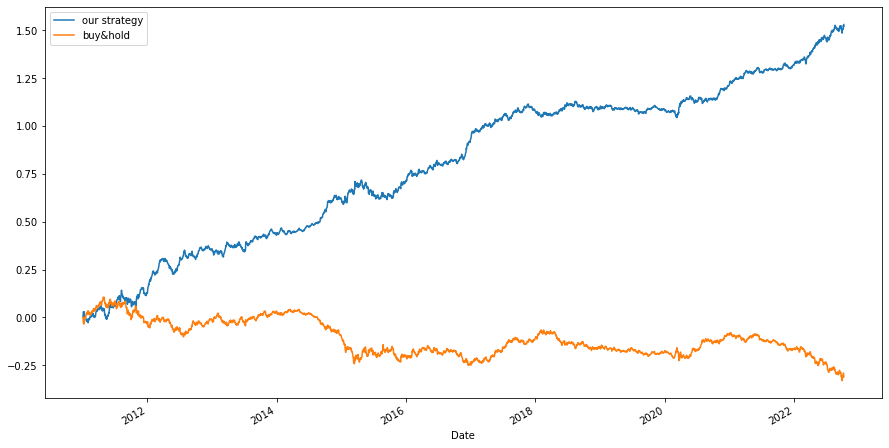

In [152]:
plt.figure(figsize=(15,8))
(train.predicted*train.logRet).cumsum().plot(label='our strategy')
train.logRet.cumsum().plot(label='buy&hold')
plt.legend()

In [153]:
# Now we test it, so we take the following period
start = '2022-10-10'
end = '2023-10-10'
interval = '1d'
test = yf.download(ticker, start=start, end=end, interval=interval)['Adj Close'].to_frame()

[*********************100%%**********************]  1 of 1 completed


In [156]:
test['logRet'] = np.log(test['Adj Close']/test['Adj Close'].shift(1))

lags = 60
col_names = []

for lag in range(1,lags+1):
    col_name = 'logRet'+str(lag)
    col_names.append(col_name)
    test[col_name] = test['logRet'].shift(lag)
    
test.dropna(inplace=True)

In [157]:
# We must use the model we trained before
test['predicted'] = lm2022.predict(test[col_names])

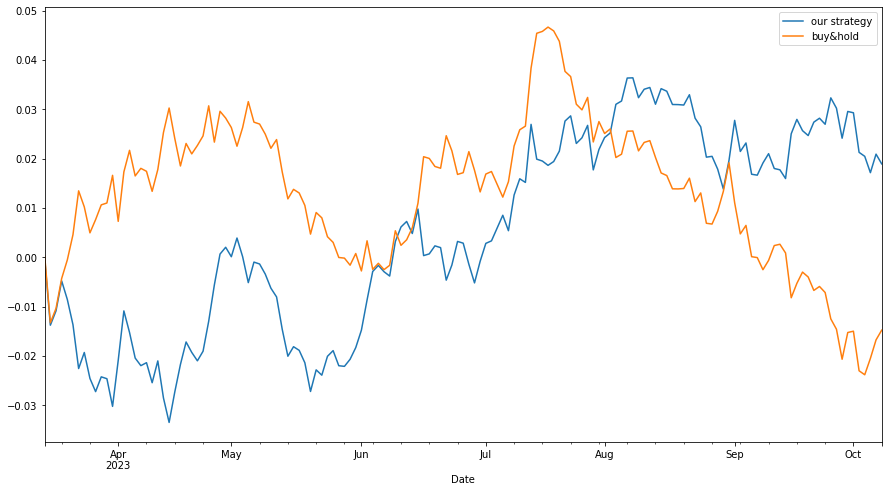

In [158]:
plt.figure(figsize=(15,8))
(test.predicted*test.logRet).cumsum().plot(label='our strategy')
test.logRet.cumsum().plot(label='buy&hold')
plt.legend()

In [159]:
# Add the transaction costs
test['transactions'] = abs(test.predicted-test.predicted.shift(1))

In [160]:
comm=0.0
spread=0.00008/test['Adj Close'].mean()

In [161]:
test.dropna(inplace=True)

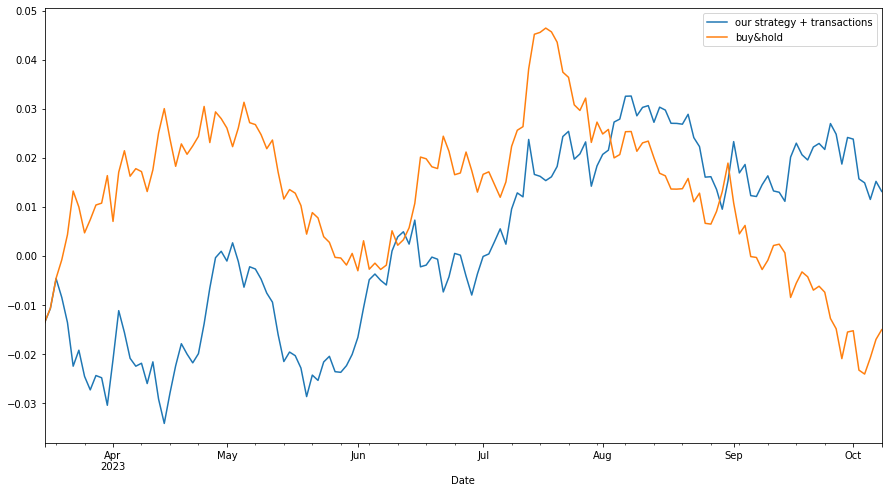

In [162]:
plt.figure(figsize=(15,8))
(test.predicted*test.logRet-test.transactions*(comm+spread/2)).cumsum().plot(label='our strategy + transactions')
test.logRet.cumsum().plot(label='buy&hold')
plt.legend()